In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
import matplotlib.pyplot as plt

from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader as TimeSeriesLoaderFast
from nixtla.data.tsloader_pinche import TimeSeriesLoader as TimeSeriesLoaderPinche
from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

from nixtla.models.nbeats.nbeats import Nbeats

## READ NORD POOL ELECTRICITY PRICE FORECASTING DATASET

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
sum(train_outsample_mask)
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_train_mask=train_outsample_mask)
# print('X: time series features, of shape (#series,#times,#features): \t' + str(X.shape))
# print('Y: target series (in X), of shape (#series,#times): \t \t' + str(Y.shape))
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
Y_df.head()

Processing dataframes ...
Creating ts tensor ...


,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


## TRAIN AND VALIDATION DATALOADERS

In [3]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                    model='nbeats',
                                    offset=24,
                                    window_sampling_limit=365*4*24, 
                                    input_size=7*24,
                                    output_size=24,
                                    idx_to_sample_freq=1,
                                    batch_size=1024,
                                    is_train_loader=True)

val_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                  model='nbeats',
                                  offset=24,
                                  window_sampling_limit=365*4*24, 
                                  input_size=7*24,
                                  output_size=24,
                                  idx_to_sample_freq=1,
                                  batch_size=1024,
                                  is_train_loader=False)

In [11]:
nbeatsx = Nbeats(input_size_multiplier=7,
                 output_size=24,
                 shared_weights=False,
                 activation='relu',
                 initialization='lecun_normal',
                 stack_types=['exogenous_tcn']+1*['identity'],
                 n_blocks=2*[1],
                 n_layers=2*[2],
                 n_hidden=2*[[256,256]],
                 n_harmonics=1,
                 n_polynomials=2,
                 exogenous_n_channels=9,
                 include_var_dict={'y': [-2, -3, -8],
                                   'Exogenous1': [-1, -2, -8],
                                   'Exogenous2': [-1, -2, -8],
                                   'week_day': [-1]},
                 t_cols=epf_dataset.t_cols,
                 batch_normalization=False,
                 dropout_prob_theta=0.01,
                 dropout_prob_exogenous=0.01,
                 x_s_n_hidden=0,
                 learning_rate=0.0005,
                 lr_decay=0.5,
                 n_lr_decay_steps=3,
                 weight_decay=0.0000001,
                 l1_theta=0.0001,
                 n_iterations=50,
                 early_stopping=10,
                 loss='MAE',
                 frequency='H',
                 random_seed=1,
                 seasonality=24)

nbeatsx.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_steps=10)

============================== Start fitting ==============================
Number of exogenous variables: 10
Number of static variables: 0 , with dim_hidden: 0
Number of iterations: 50
Number of blocks: 2
Step: 10, Time: 5.625, Insample MAE: 483257.31250, Outsample MAE: 766068.75000
Step: 20, Time: 11.988, Insample MAE: 283249.37500, Outsample MAE: 526621.81250
Step: 30, Time: 18.319, Insample MAE: 377334.87500, Outsample MAE: 220889.65625
Step: 40, Time: 24.744, Insample MAE: 101773.57031, Outsample MAE: 41083.08984
Step: 50, Time: 31.078, Insample MAE: 46306.52734, Outsample MAE: 25445.63086
Iteration: 50, Time: 31.305, Insample MAE: 46306.52734, Outsample MAE: 25484.13672
==============================End fitting ==============================


In [12]:
y_hat = nbeatsx.predict(ts_loader=train_loader)

forecasts (1, 24)


## READ TURISM DATASET

In [13]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo
group = TourismInfo.groups[0]
print("TourismInfo.groups[0]", group)
Y_df, _ = Tourism.load(directory='data', group=group)
tourism_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=None, ts_train_mask=None)

TourismInfo.groups[0] Yearly
Processing dataframes ...
Creating ts tensor ...


In [14]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=tourism_dataset,
                                            model='nbeats',
                                            offset=4,
                                            window_sampling_limit=20*4, 
                                            input_size=7*4,
                                            output_size=4,
                                            idx_to_sample_freq=1,
                                            batch_size= 1024,
                                            n_series_per_batch=32,
                                            is_train_loader=True)

In [15]:
nbeatsx = Nbeats(input_size_multiplier=7,
                 output_size=4,
                 shared_weights=False,
                 activation='relu',
                 initialization='lecun_normal',
                 stack_types=30*['identity'],
                 n_blocks=30*[1],
                 n_layers=30*[4],
                 n_hidden=30*[[512,512,512,512]],
                 n_harmonics=1,
                 n_polynomials=2,
                 exogenous_n_channels=9,
                 include_var_dict=None,
                 t_cols=tourism_dataset.t_cols,
                 batch_normalization=False,
                 dropout_prob_theta=0.0,
                 dropout_prob_exogenous=0.0,
                 x_s_n_hidden=0,
                 learning_rate=0.001,
                 lr_decay=0.5,
                 n_lr_decay_steps=3,
                 weight_decay=0.0000000,
                 l1_theta=0.0000,
                 n_iterations=30,
                 early_stopping=10,
                 loss='MAPE',
                 frequency='M',
                 random_seed=1,
                 seasonality=4)

nbeatsx.fit(train_ts_loader=train_loader, val_ts_loader=None, verbose=True, eval_steps=5)

============================== Start fitting ==============================
Number of exogenous variables: 0
Number of static variables: 0 , with dim_hidden: 0
Number of iterations: 30
Number of blocks: 30
Step: 5, Time: 10.036, Insample MAPE: 0.29095
Step: 10, Time: 20.104, Insample MAPE: 0.28458
Step: 15, Time: 30.572, Insample MAPE: 0.28687
Step: 20, Time: 40.947, Insample MAPE: 0.23762
Step: 25, Time: 51.183, Insample MAPE: 0.24676
Step: 30, Time: 61.352, Insample MAPE: 0.28287
Iteration: 34, Time: 61.359, Insample MAPE: 0.28287
==============================End fitting ==============================


In [16]:
y_hat = nbeatsx.predict(train_loader)

forecasts (518, 4)


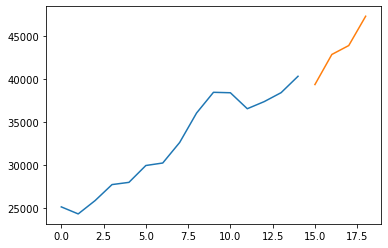

In [17]:
y_plot = Y_df[Y_df['unique_id']=='Y1']['y']
y_hat_plot = y_hat[y_hat['unique_id']=='Y1']['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)

# Should be around 22

In [18]:
y_test = Y_df.groupby('unique_id').tail(4).reset_index(drop=True)
np.mean(np.abs(y_test['y']-y_hat['y_hat'])/np.abs(y_test['y']))

0.2205189186011943